In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#pip install statsmodels pmdarima matplotlib pandas


In [2]:
# Charger les données prétraitées
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True, index_col=0)

# Assurez-vous que l'index est au format datetime
df.index = pd.to_datetime(df.index)

# Identifier les colonnes à prédire (toutes sauf la date)
target_columns = df.columns.tolist()

# Dictionnaire pour stocker les prédictions
forecast_results = {}


Training SARIMA model for beer...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=118.308, Time=2.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=144.601, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=131.067, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=121.316, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=143.172, Time=0.04 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=116.805, Time=2.43 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=117.362, Time=1.29 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=118.794, Time=11.64 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=116.389, Time=2.17 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=117.870, Time=8.26 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=120.380, Time=8.13 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=120.810, Time=2.59 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=115.148, Time=2.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=117.177, Time=0.71 se

C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


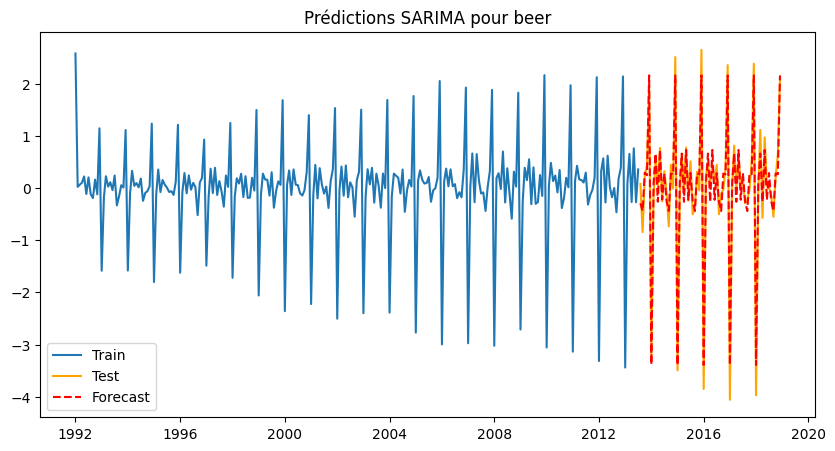

Toutes les prédictions SARIMA ont été enregistrées.


In [3]:
for column in target_columns:
    print(f"Training SARIMA model for {column}...")

    # Séparer train/test (80/20)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index][column]
    test_df = df.iloc[split_index:][column]

    # Trouver les meilleurs paramètres (p, d, q, P, D, Q, s) automatiquement
    auto_model = auto_arima(train_df, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
    best_order = auto_model.order  # (p, d, q)
    best_seasonal_order = auto_model.seasonal_order  # (P, D, Q, s)

    print(f"Best SARIMA Order for {column}: {best_order}, Seasonal: {best_seasonal_order}")

    # Entraîner le modèle SARIMA avec les paramètres trouvés
    model = SARIMAX(train_df, 
                    order=best_order, 
                    seasonal_order=best_seasonal_order,
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    sarima_model = model.fit(disp=False)

    # Faire des prédictions
    forecast = sarima_model.forecast(steps=len(test_df))

    # Sauvegarder les résultats
    forecast_results[column] = pd.DataFrame({"ds": test_df.index, "yhat": forecast.values})

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(train_df.index, train_df, label="Train")
    plt.plot(test_df.index, test_df, label="Test", color="orange")
    plt.plot(test_df.index, forecast, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"Prédictions SARIMA pour {column}")
    plt.legend()
    plt.show()

# Sauvegarder les prévisions
for col, forecast in forecast_results.items():
    forecast.to_csv(f"forecast_sarima_{col}.csv", index=False)

print("Toutes les prédictions SARIMA ont été enregistrées.")
